# Spanning Trees on Grid Graph, Complete Graph, and Complete Bipartite Graph Partitions
*Samuel Rabinowitz*

# Brief Explanation
(I intend to make this into more of a final product at some point. This here is mostly just an informal exposé.)

## Introduction

It is often necessary to partition a graph into multiple connected components. In particular, graph partitioning is applicable in the study of districting plans, as shown in the work of the [Metric Geometry and Gerrymandering Group at Tisch College of Tufts University](https://mggg.org/), led by Dr. Moon Duchin. In DeFord et al., members of this lab propose two algorithms that can iteratively generate partition plans, which they refer to as Flip and ReCom. In fact, partitioning a graph is a relatively easy task, but since the space of partitions is too large to enumerate for most graphs, it can be difficult to characterize these partitions. Therefore, we find ourselves using Markov chain Monte Carlo (MCMC) sampling to characterize the state space.

Clelland et al. use MCMC to study the relationship between cut edges $E_D$ in a partition plan $D$, and a certain spanning tree statistic, $P_D$, where
$$P_D = T_{D_1} T_{D_2} E_D$$
and $T_{D_i}$ is the number of possible spanning trees in component $D_i$ of partition plan $D$. The spanning tree statistic is significant in DeFord et al.'s ReCom algorithm, since we can interpret $P_D$ as a measure of likelihood for randomly generating $D$.

An interesting result from Clelland et al. is that
$$P_D \approx C e^{-k E_D}$$
for positive real constants $C$ and $k$. Therefore, the likelihood of generating a specific partition in the ReCom algorithm can be seen as exponentially decaying on the number of cut edges. Essentially, we expect ReCom to favor partitions with fewer cut edges, and this is consistent with the images shown in DeFord et al. that compare relatively smooth ReCom plans with Flip plans that have much more cut edges. However, Clelland et al. only studied this relationship on a $12$ by $12$ grid graph and did not discuss how $C$ and $k$ can be determined.

## Methodology

I first tried to replicate the results of Clelland et al. using the GerryChainJulia Julia package and similarly observed that for a $12$ by $12$ grid graph,
$$P_D = T_{D_1} T_{D_2} E_D \approx C e^{-k E_D}$$
for some graph-specific constants $C$ and $k$. I extended this initial exploration by comparing multiple square grid graphs of different sizes and determined the values of $C$ and $k$ using an ordinary least squares regression, where I noticed that $C$ is exponentially related to $|V|$, the number of vertices. There is also a relation between $|V|$ and $k$, but it is harder to describe, so I mainly looked at $C$. Then, I looked at non-square rectangular grid graphs and noticed that $C$ still appeared as an exponential function of $|V|$. So for a grid graph $G$, I suggest that
$$C_G \approx \alpha e^{\beta |V_G|}$$
for some $\alpha, \beta > 0$.

I then looked at complete bipartite graphs and similarly found that when $G$ is a complete bipartite graph,
$$C_G \approx \alpha' e^{\beta' |V_G|}$$
for some $\alpha', \beta' > 0$. However, $\alpha' \neq \alpha$ and $\beta' \neq \beta$, so the value of $C_G$ for a graph with $|V|$ vertices seems to depend on which class of graphs $G$ belongs to. We expect a $16$ by $4$ and an $8$ by $8$ grid graph to have similar values $C_G$, and we expect $K_{32, 32}$ and $K_{48, 16}$ (where $K_{i, j}$ is a complete bipartite graph) to have similar values $C_G$, but we do not expect the $16$ by $4$ grid graph to have the same $C_G$ as $K_{32, 32}$, even though these graphs both have $64$ vertices. This fact presents a very stark distinction between grid graphs and complete bipartite graphs.

## Acknowledgements

Thanks to [Jonathan Conroy](https://github.com/jconroy14) for helping me get started with GerryChainJulia and giving me starter code to generate the graph files. This is all part of our final presentation for Math 260: Markov chains Monte Carlo in spring 2021 at Tufts University, taught by Dr. Moon Duchin.

## Bibliography

Clelland, Jeanne N, Nicholas Bossenbroek, Thomas Heckmaster, Adam
Nelson, Peter Rock, and Jade VanAusdall. 2021. "First Steps Towards
Quantifying District Compactness in the ReCom Sampling Method." *arXiv
Preprint arXiv:2103.02699*.

DeFord, Daryl, Moon Duchin, and Justin Solomon. 2019. "Recombination: A
Family of Markov Chains for Redistricting."
<https://arxiv.org/abs/1911.05725>.

Rule, Parker, Matthew Sun, and Bhushan Suwal. 2021.
"Mggg/GerryChainJulia: Minor Fixes + Save as Hdf5." Zenodo.
<https://doi.org/10.5281/zenodo.4649464>.

# Code

## Imports

In [1]:
using LinearAlgebra
using SparseArrays
using Arpack
using GerryChain
using Plots
using GLM
using DataFrames
LA = LinearAlgebra;

## Markov Chain Monte Carlo Functions

In [2]:
# Given a BaseGraph, extract the
# adjacency matrix

function get_adj_matrix(bgrph::BaseGraph)
    A = copy(bgrph.adj_matrix)
    A[A .!= 0] .= 1
    return A
end

# Given an adjacency matrix A, compute the
# number of spanning trees

function log_n_spanners_adj(A::SparseMatrixCSC{Int, Int})::Float64
    D = LA.Diagonal(vec(LA.sum(A, dims = 1)))
    L = D - A
    # return LA.logdet(L[2:end, 2:end]) - log(size(A)[1])
    vals = Arpack.eigs(L, nev = size(L)[1] - 1)[1]
    return LA.sum(log.(vals)) - log(size(A)[1])
end

# Given a BaseGraph and a Partition, compute the logarithm
# of the number of spanning trees in each component multiplied

function log_n_spanners_plan(grph::BaseGraph, part::Partition)::Float64
    A = get_adj_matrix(grph)
    ts = 0
    es = 0
    for i in 1:part.num_dists
        nodes = [nd for nd in part.dist_nodes[i]]
        ts = ts + log_n_spanners_adj(A[nodes, nodes])
        for j in 1:(i - 1)
            es = es + log(max(1, part.dist_adj[i, j]))
        end
    end
    return ts + es
end

# Generate default scoring objects

function my_scores()
    return [
        num_cut_edges("E_D"),
        PlanScore("log(P_D)", log_n_spanners_plan)
    ]
end

# Run a ReCom chain

function do_recom_chain(
        bgrph::BaseGraph,
        part::Partition,
        num_steps::Int)::ChainScoreData
    scores = my_scores()
    pop_constr = PopulationConstraint(bgrph, part, 0.)
    println("    Running chain with ", num_steps, " steps...")
    return recom_chain(bgrph, part, pop_constr, num_steps, scores)
end

# Run a flip chain

function do_flip_chain(
        bgrph::BaseGraph,
        part::Partition,
        num_steps::Int)::ChainScoreData
    scores = my_scores()
    pop_constr = PopulationConstraint(bgrph, part, 0.5)
    cont_constr = ContiguityConstraint()
    println("    Running chain with ", num_steps, " steps...")
    return flip_chain(bgrph, part, pop_constr, cont_constr, num_steps, scores)
end

do_flip_chain (generic function with 1 method)

In [3]:
# Plot the spanning tree statistic for given chains.

function plot_spanning(flip_csdata::ChainScoreData, recom_csdata::ChainScoreData)
    fes = get_score_values(flip_csdata, "E_D")[2:end]
    fps = get_score_values(flip_csdata, "log(P_D)")[2:end]
    res = get_score_values(recom_csdata, "E_D")[2:end]
    rps = get_score_values(recom_csdata, "log(P_D)")[2:end]
    scatter(fes, fps, label = "Flip Chain")
    scatter!(res, rps, label = "ReCom Chain")
    xlabel!(raw"$E_D$")
    ylabel!(raw"$\log(P_D)$")
end

plot_spanning (generic function with 1 method)

## Regression

We assume that
$$P_D \approx C e^{-k E_D},$$
so
$$\log(P_D) \approx \log(C) - k E_D = a + b E_D$$
and
$$C = e^a, \quad k = -b.$$

In [4]:
function get_Ck(csdata::ChainScoreData)::Tuple{Float64,Float64}
    es = get_score_values(csdata, "E_D")[2:end]
    ps = get_score_values(csdata, "log(P_D)")[2:end]
    df = DataFrame(X = es, Y = ps)
    ols = lm(@formula(Y ~ X), df)
    ab = coef(ols)
    C = exp(ab[1])
    k = -ab[2]
    return C, k
end

get_Ck (generic function with 1 method)

## Import Graph Data

In [5]:
cd("graphs");

In [6]:
gdirs = readdir()
n_dirs = size(gdirs)[1]

# Number of steps in ReCom chain

num_steps = 512

# Number of steps in Flip chain

num_steps_flip = 1024

# Each directory corresponds to a
# different type of graph we will
# look at

Css = [[] for i in 1:n_dirs]
kss = [[] for i in 1:n_dirs]
num_nodess = [[] for i in 1:n_dirs]
num_edgess = [[] for i in 1:n_dirs];

In [7]:
# Initialize the data to all zeros

for i in 1:n_dirs
    cd(gdirs[i])
    gfiles = readdir()
    n_files = size(gfiles)[1]
    Css[i] = zeros(Float64, n_files)
    kss[i] = zeros(Float64, n_files)
    num_nodess[i] = zeros(Int64, n_files)
    num_edgess[i] = zeros(Int64, n_files)
    cd("..")
end

## Run the MCMC and Compute Relevant Data

In [8]:
# Each file represents a graph, so we will iterate through
# each graph and generate spanning tree statistics

for i in 1:n_dirs
    println("Processing directory ", gdirs[i], "...")
    cd(gdirs[i])
    gfiles = readdir()
    n_files = size(gfiles)[1]
    for j in 1:n_files
        println("    Processing file ", gfiles[j], "...")
        bgrph = BaseGraph(gfiles[j], "population")
        num_nodess[i][j] = bgrph.num_nodes
        num_edgess[i][j] = bgrph.num_edges
        part = Partition(bgrph, "district")
        if(gfiles[j][end] == 'f')
            csdata = do_flip_chain(bgrph, part, 1024)
        else
            csdata = do_recom_chain(bgrph, part, 512)
        end
        Css[i][j], kss[i][j] = get_Ck(csdata)
    end
    cd("..")
end

Processing directory K_41r...
    Processing file completebipartitegraph_112x28.json...
    Running chain with 512 steps...
    Processing file completebipartitegraph_128x32.json...
    Running chain with 512 steps...
    Processing file completebipartitegraph_144x36.json...
    Running chain with 512 steps...
    Processing file completebipartitegraph_160x40.json...
    Running chain with 512 steps...
    Processing file completebipartitegraph_176x44.json...
    Running chain with 512 steps...
    Processing file completebipartitegraph_192x48.json...
    Running chain with 512 steps...
    Processing file completebipartitegraph_64x16.json...
    Running chain with 512 steps...
    Processing file completebipartitegraph_80x20.json...
    Running chain with 512 steps...
    Processing file completebipartitegraph_96x24.json...
    Running chain with 512 steps...
Processing directory K_42r...
    Processing file completebipartitegraph_32x16.json...
    Running chain with 512 steps...
    

## Plotting Functions

In [19]:
# Plot the data.

function make_plot(Xs, Ys, gdirs, xlabel, ylabel)
    n_dirs = size(gdirs)[1]
    for i in 1:n_dirs
        func = (i == 1) ? scatter : scatter!
        label = gdirs[i][1:end - 1]
        func(Xs[i], Ys[i], label = label)
    end
    ylabel!(ylabel)
    xlabel!(xlabel)
    return title!(string(
            raw"$\mathrm{constants} \: C,",
            raw" k, \: \mathrm{given} \: ",
            raw"P_D = T_{D_1} T_{D_2} E_D",
            raw" \approx C e^{-k E_D}$"))
end

# Display the plot using the better looking
# HTML format, and then display it again as
# a png for easy copy and paste.

function display_twice(plt)
    display(plt)
    plot!(fmt = :png)
    display(plt)
end

display_twice (generic function with 1 method)

## Plot the Data

In [13]:
logCss = [log.(Cs) for Cs in Css];
# logkss = [log.(ks) for ks in kss]

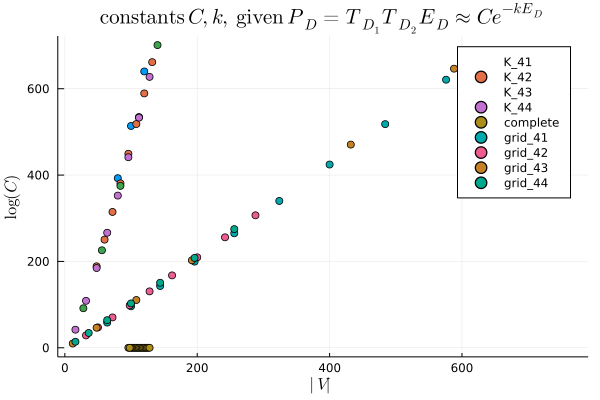

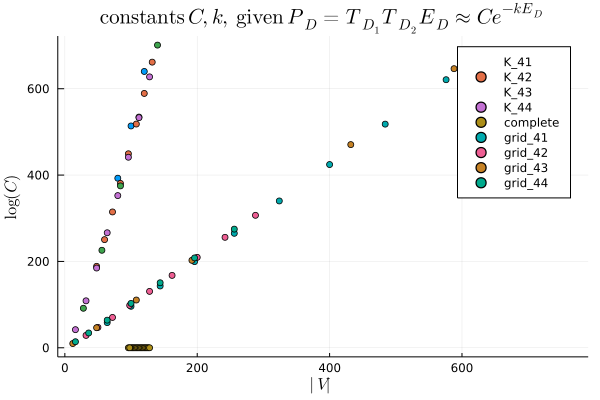

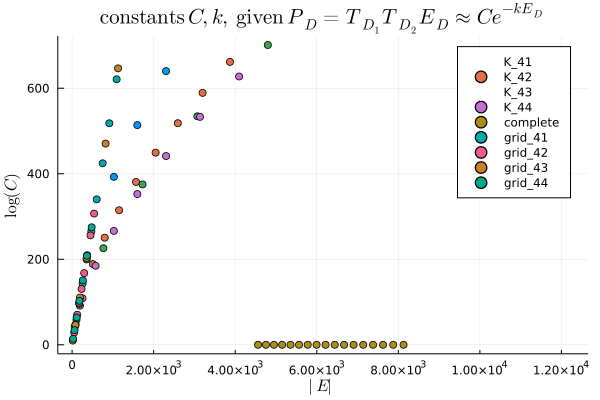

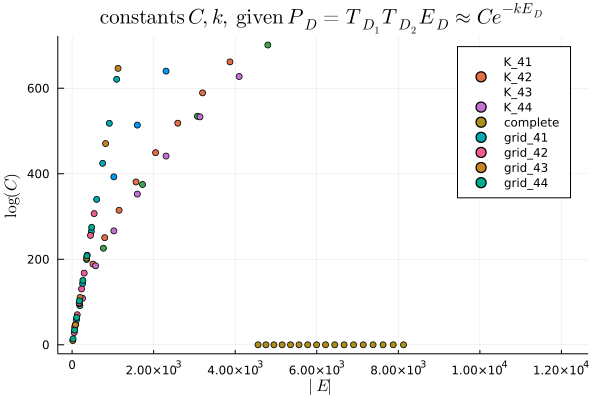

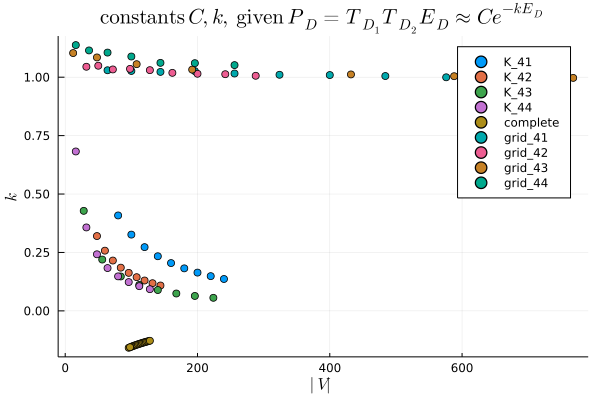

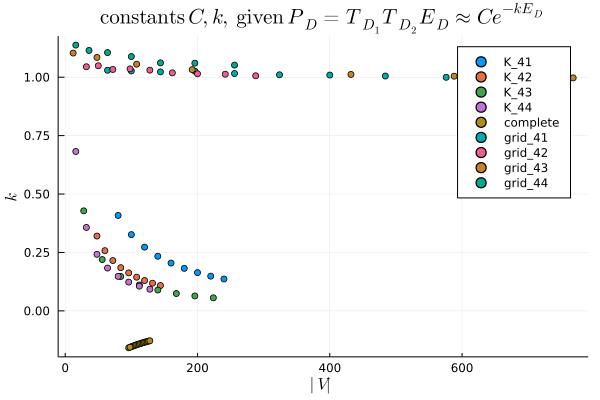

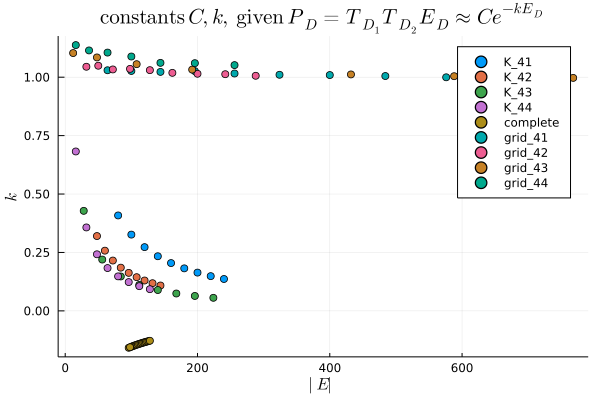

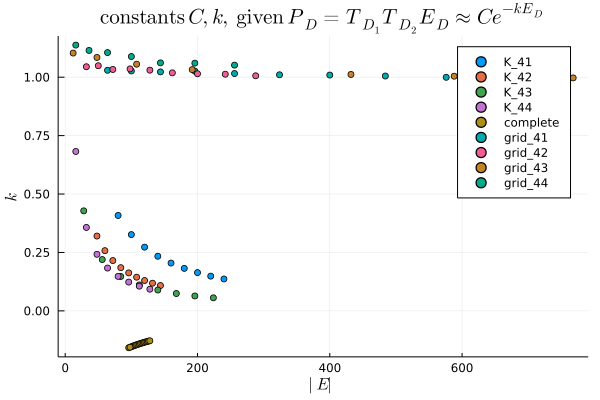

In [20]:
plt = make_plot(num_nodess, logCss, gdirs, raw"$|V|$", raw"$\log(C)$");
display_twice(plt)
plt = make_plot(num_edgess, logCss, gdirs, raw"$|E|$", raw"$\log(C)$");
display_twice(plt)
#plt = make_plot(num_nodess, log.(kss), gdirs, raw"$|V|$", raw"$\log(k)$");
#display_twice(plt)
#plt = make_plot(num_nodess, log.(kss), gdirs, raw"$|E|$", raw"$\log(k)$");
#display_twice(plt)
plt = make_plot(num_nodess, kss, gdirs, raw"$|V|$", raw"$k$");
display_twice(plt)
plt = make_plot(num_nodess, kss, gdirs, raw"$|E|$", raw"$k$");
display_twice(plt)

## Extra: Plot Focused Data

In [21]:
print(gdirs)

["K_41r", "K_42r", "K_43r", "K_44r", "completef", "grid_41r", "grid_42r", "grid_43r", "grid_44r"]

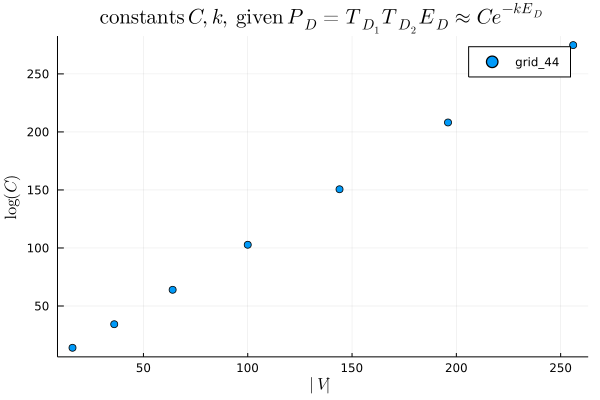

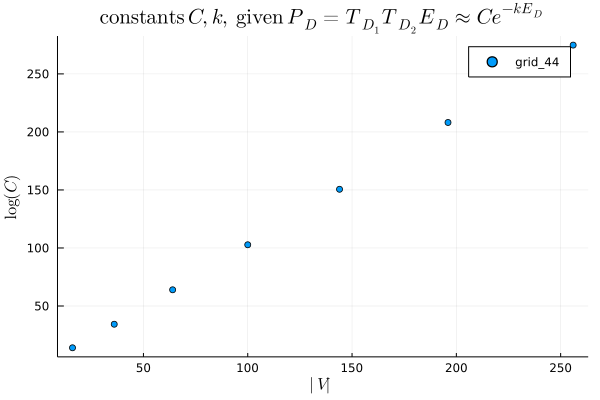

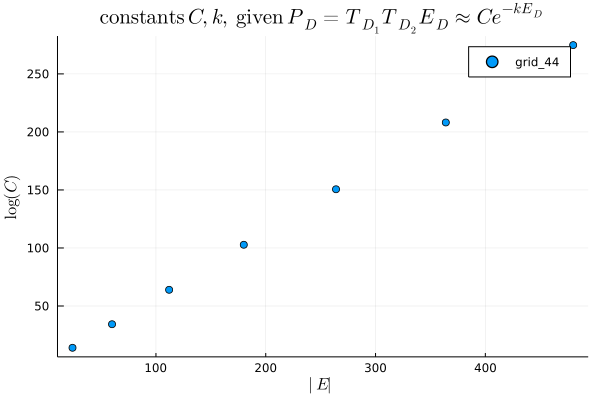

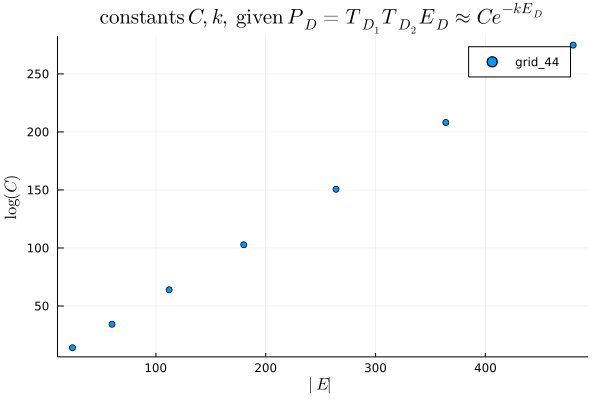

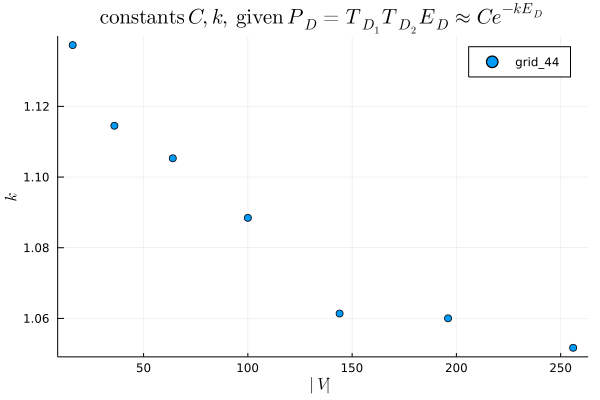

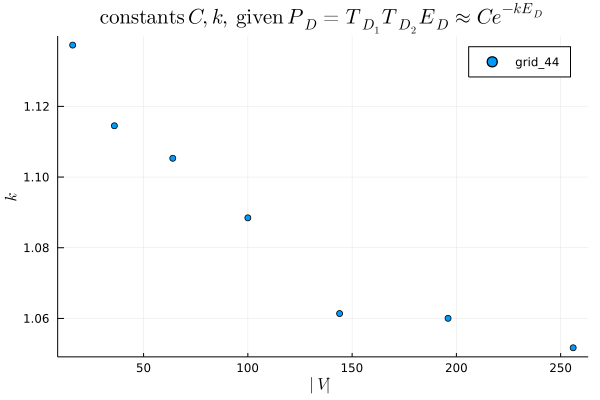

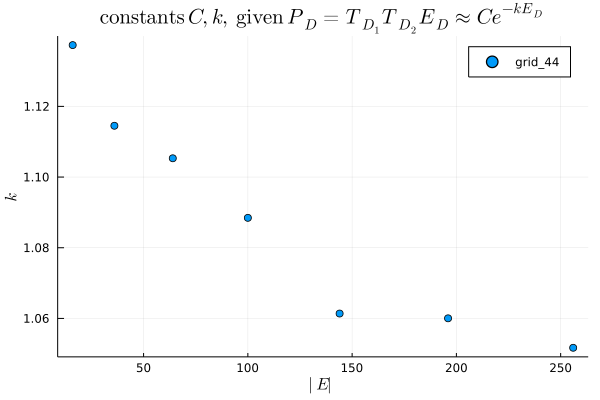

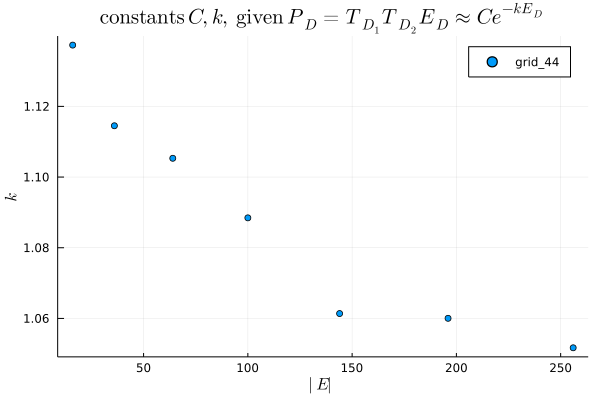

In [23]:
plt = make_plot([num_nodess[9]], [logCss[9]], [gdirs[9]], raw"$|V|$", raw"$\log(C)$");
display_twice(plt)
plt = make_plot([num_edgess[9]], [logCss[9]], [gdirs[9]], raw"$|E|$", raw"$\log(C)$");
display_twice(plt)
#plt = make_plot(num_nodess, log.(kss), gdirs, raw"$|V|$", raw"$\log(k)$");
#display_twice(plt)
#plt = make_plot(num_nodess, log.(kss), gdirs, raw"$|E|$", raw"$\log(k)$");
#display_twice(plt)
plt = make_plot([num_nodess[9]], [kss[9]], [gdirs[9]], raw"$|V|$", raw"$k$");
display_twice(plt)
plt = make_plot([num_nodess[9]], [kss[9]], [gdirs[9]], raw"$|E|$", raw"$k$");
display_twice(plt)

In [26]:
grid_logkss = [log.(ks) for ks in kss[6:9]];

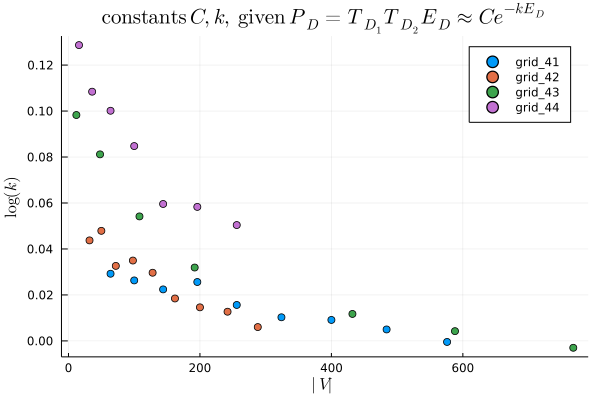

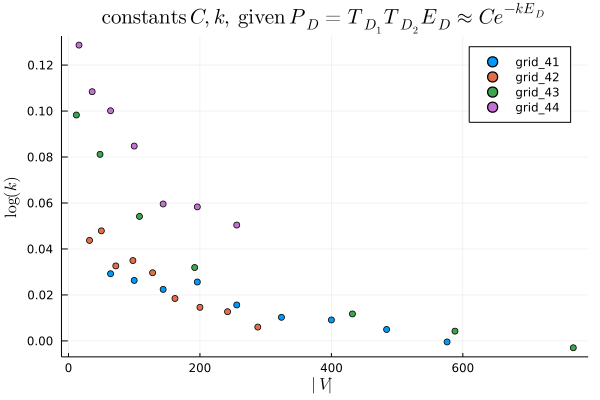

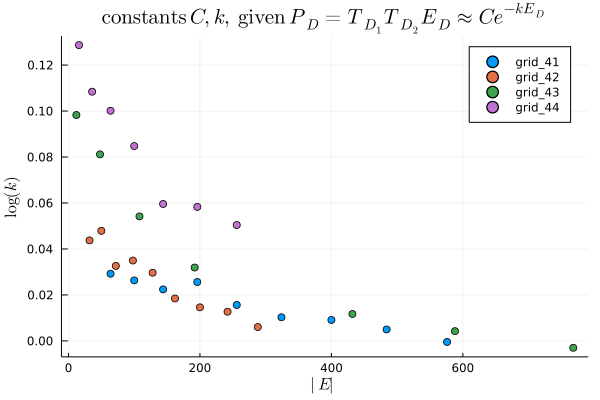

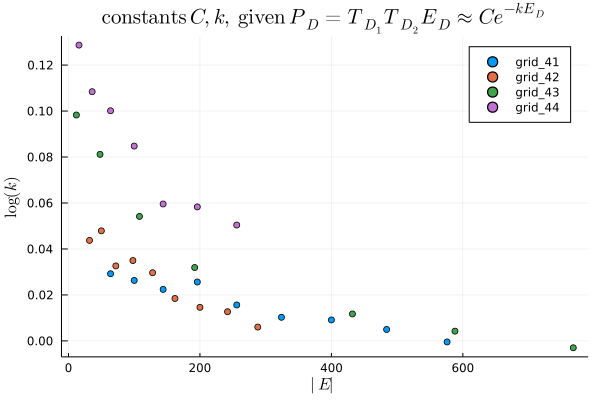

In [27]:
plt = make_plot(num_nodess[6:9], grid_logkss, gdirs[6:9], raw"$|V|$", raw"$\log(k)$");
display_twice(plt)
plt = make_plot(num_nodess[6:9], grid_logkss, gdirs[6:9], raw"$|E|$", raw"$\log(k)$");
display_twice(plt)

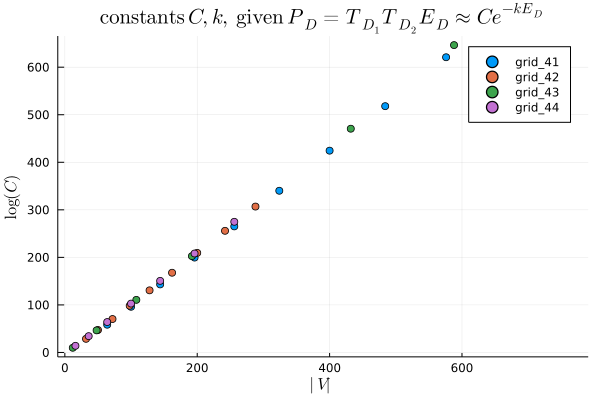

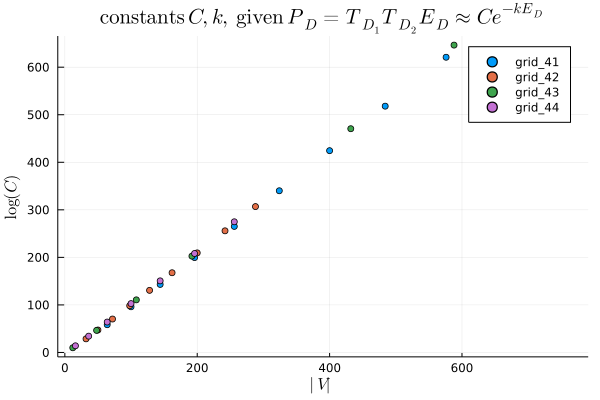

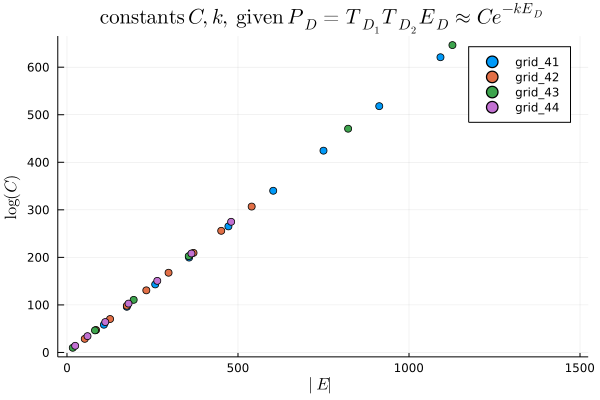

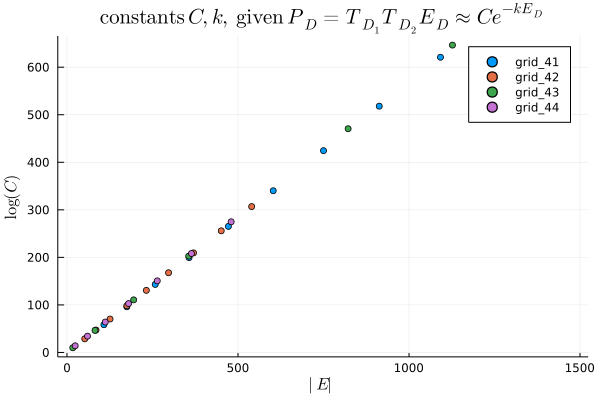

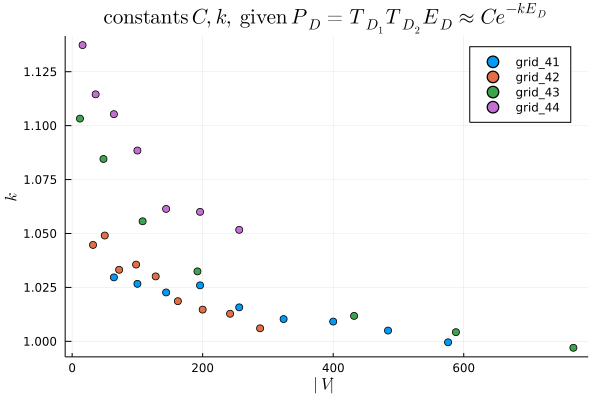

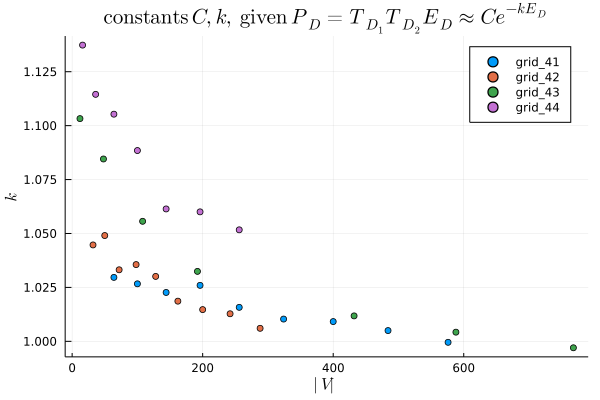

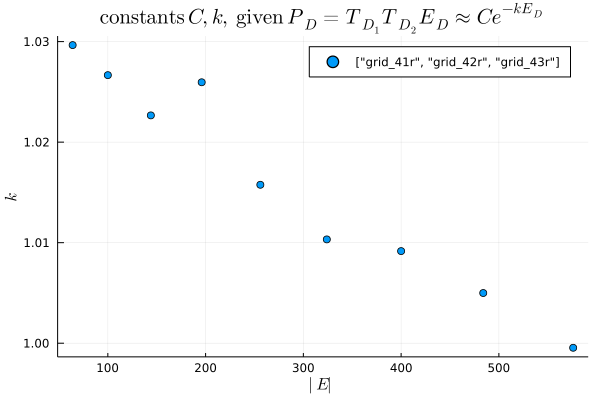

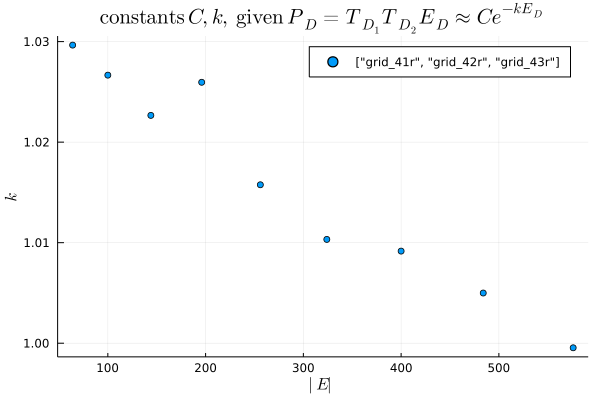

In [24]:
plt = make_plot(num_nodess[6:9], logCss[6:9], gdirs[6:9], raw"$|V|$", raw"$\log(C)$");
display_twice(plt)
plt = make_plot(num_edgess[6:9], logCss[6:9], gdirs[6:9], raw"$|E|$", raw"$\log(C)$");
display_twice(plt)
#plt = make_plot(num_nodess, log.(kss), gdirs, raw"$|V|$", raw"$\log(k)$");
#display_twice(plt)
#plt = make_plot(num_nodess, log.(kss), gdirs, raw"$|E|$", raw"$\log(k)$");
#display_twice(plt)
plt = make_plot(num_nodess[6:9], kss[6:9], gdirs[6:9], raw"$|V|$", raw"$k$");
display_twice(plt)
plt = make_plot(num_nodess[6:9], kss[6:9], [gdirs[6:9]], raw"$|E|$", raw"$k$");
display_twice(plt)

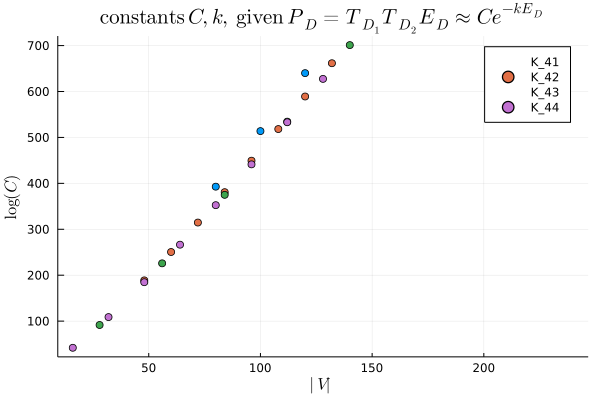

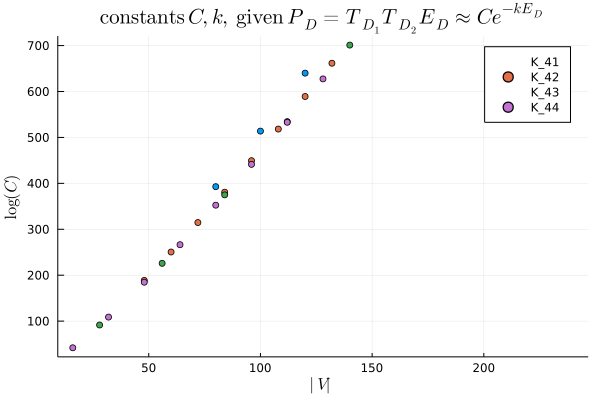

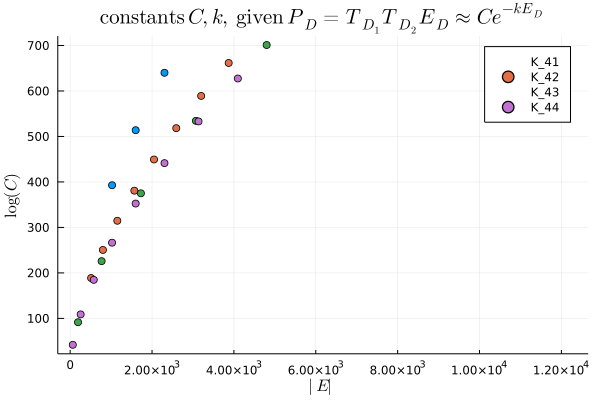

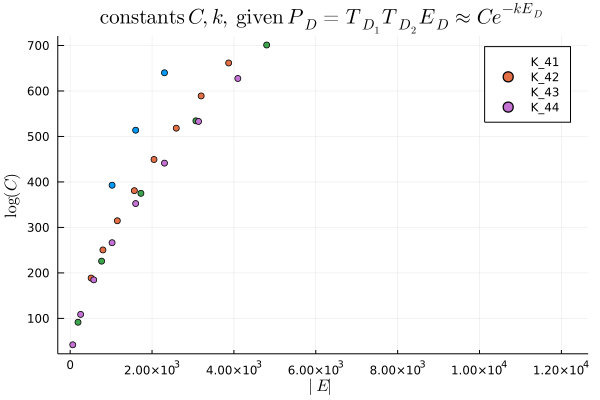

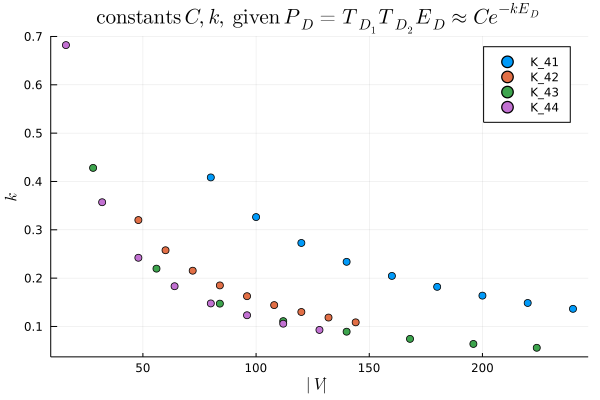

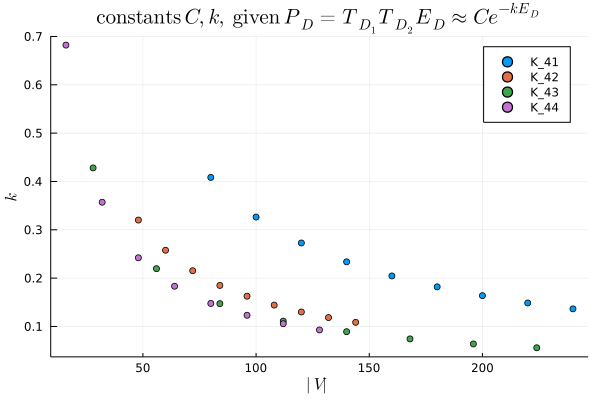

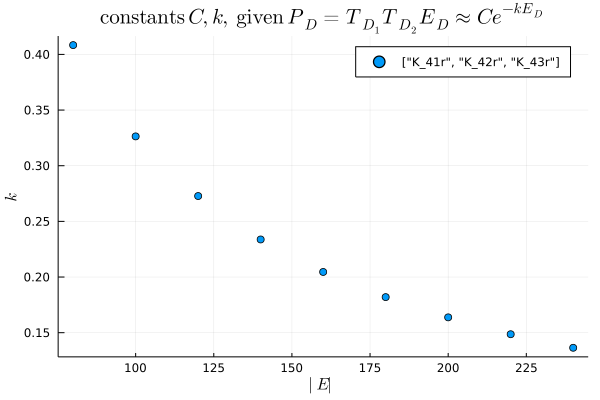

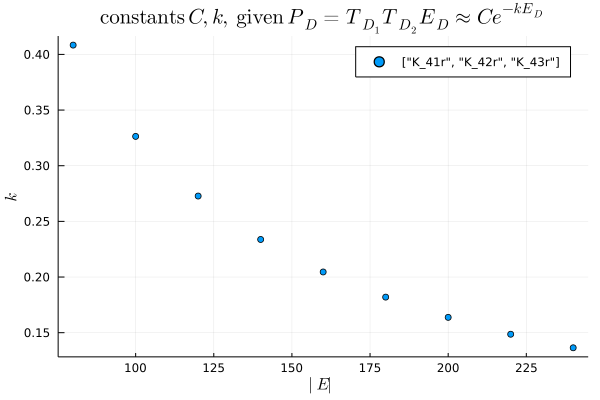

In [28]:
plt = make_plot(num_nodess[1:4], logCss[1:4], gdirs[1:4], raw"$|V|$", raw"$\log(C)$");
display_twice(plt)
plt = make_plot(num_edgess[1:4], logCss[1:4], gdirs[1:4], raw"$|E|$", raw"$\log(C)$");
display_twice(plt)
#plt = make_plot(num_nodess, log.(kss), gdirs, raw"$|V|$", raw"$\log(k)$");
#display_twice(plt)
#plt = make_plot(num_nodess, log.(kss), gdirs, raw"$|E|$", raw"$\log(k)$");
#display_twice(plt)
plt = make_plot(num_nodess[1:4], kss[1:4], gdirs[1:4], raw"$|V|$", raw"$k$");
display_twice(plt)
plt = make_plot(num_nodess[1:4], kss[1:4], [gdirs[1:4]], raw"$|E|$", raw"$k$");
display_twice(plt)